setup device agnostic code

In [32]:
import torch
from torch import nn
from torchvision import transforms, datasets, models

device = "cuda" if torch.cuda.is_available() else "cpu"

display a random image and see what it looks like as an array

Grade5
Image path: dataset/test/Grade5/img985roi4308id79.tiff
Image class: Grade5
Image height: 500
Image width: 500
Image shape: (500, 500, 3)


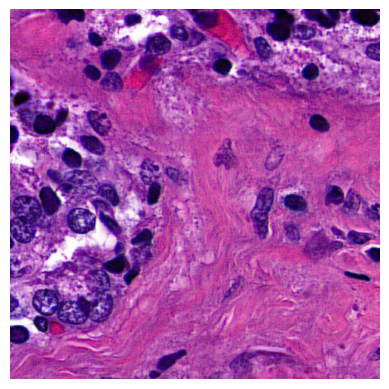

In [17]:
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path("dataset")

# 1. Get all image paths
image_path_list = list(data_path.glob("*/*/*.tiff"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)
plt.imshow(img)
plt.axis(False)

# 5. Print metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

import numpy as np

# turn the image into an array
img_as_array = np.asarray(img)
print(f"Image shape: {img_as_array.shape}")

transforming data

In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# write a transform for image
data_transform = transforms.Compose([
    # resize to be half as large
    transforms.Resize(250),
    transforms.RandomCrop(240),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # crop to resnet input size
    transforms.CenterCrop(224),
    # Flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

train_dir = data_path / "train"
test_dir = data_path / "test"

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

# get class names as a list
class_names = train_data.classes
class_names

['Background', 'Grade3', 'Grade4CG', 'Grade4FG', 'Grade5', 'Unlabeled']

put data in DataLoaders and get model

In [30]:
import os
from torch.utils.data import DataLoader
from torchvision.models import resnet101
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=os.cpu_count(), shuffle=True)
model = resnet101(weights='DEFAULT')

define loss function and optimizer

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

function for printing train time

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

train model

In [1]:
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")

    # train 
    train_loss = 0

    # loop through dataloader
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        # forward pass
        y_pred = model(X)
        # calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # optimizer zero grad
        optimizer.zero_grad()
        # loss backward
        loss.backward()
        # optimizer step
        optimizer.step()

        # print what's happening
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)}")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    # testing 
    test_loss = 0
    model.eval()
    
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # forward pass
            test_pred = model(X_test)
            # calculate the loss
            test_loss += loss_fn(test_pred, y_test)
            
        # calculate the test loss average per batch
        test_loss /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

    # Calculate training time
    total_time_end_on_cpu = timer()
    

/Users/sarahrubenstein/miniconda3/envs/deep_learning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3/3 [00:00<00:00, 17549.39it/s]

Epoch: 0
----
Epoch: 1
----
Epoch: 2
----
